In [5]:
### The final code cell includes the library versions
library(lme4)
library(lmerTest)
library(easystats)
library(interactions)

library(dplyr)
library(car)
library(stats)

In [2]:
### Load the oxygen consumption rate data with regional and network label and behavioral regressors
model_data = read.csv("../data/lmer_data.csv",
                    stringsAsFactors=TRUE)

### Set reference categories for categorical predictors
model_data$condition = relevel(model_data$condition, ref="predictable")
model_data$network = relevel(model_data$network, ref="Visual")

# Model comparisons

In [26]:
# Model assuming no effect of experimental conditions or confidence level
base_model = lmer(CMRO2 ~ network + reaction_time_z + (1|subject), data=model_data, REML=FALSE)
# Test for an effect of the experimental manipulation
condition_model = lmer(CMRO2 ~ condition*network + reaction_time_z + reaction_time_z:condition + (1|subject/condition), data=model_data, REML=FALSE)
# Test whether adding confidence and its two-way interactions improve model fit
confidence_model = lmer(CMRO2 ~ condition*confidence_z + network + network:condition + network:confidence_z + reaction_time_z + reaction_time_z:condition + (1|subject/condition), data=model_data, REML=FALSE)
# Test whether a three-way interaction improves fit: Condition and confidence interact, and this interaction may vary across cortical networks
full_model = lmer(CMRO2 ~ condition*confidence_z*network + reaction_time_z + reaction_time_z:condition + (1|subject/condition), data=model_data, REML=FALSE)

### Perform likelihood ratio test and Bayes test, rounding the results for readability
round(anova(base_model, condition_model, confidence_model, full_model, test='LRT'), 3)
test_bf(base_model, condition_model, confidence_model, full_model) %>% mutate_if(is.numeric, round, digits=3)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
base_model,9,470241.6,470320.1,-235111.8,470223.6,NA,NA,NA
condition_model,24,469764.9,469974.3,-234858.5,469716.9,506.663,15,0.000
confidence_model,32,469729.7,470008.9,-234832.9,469665.7,51.229,8,0.000
full_model,42,469735.1,470101.6,-234825.5,469651.1,14.625,10,0.146


Model,log_BF,BF
<chr>,<dbl>,<dbl>
network + reaction_time_z + (1 | subject),NA,NA
condition * network + reaction_time_z + reaction_time_z:condition + (1 | condition:subject) + (1 | subject),172.890,1.216163e+75
condition * confidence_z + network + network:condition + network:confidence_z + reaction_time_z + reaction_time_z:condition + (1 | condition:subject) + (1 | subject),155.602,3.775924e+67
condition * confidence_z * network + reaction_time_z + reaction_time_z:condition + (1 | condition:subject) + (1 | subject),109.286,2.899377e+47


In [16]:
# Fit the winning model using REML
confidence_model = lmer(CMRO2 ~ condition*confidence_z + network + network:condition + network:confidence_z + reaction_time_z + reaction_time_z:condition + (1|subject/condition), data=model_data, REML=TRUE)
summary(confidence_model)


Correlation matrix not shown by default, as p = 29 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: CMRO2 ~ condition * confidence_z + network + network:condition +  
    network:confidence_z + reaction_time_z + reaction_time_z:condition +  
    (1 | subject/condition)
   Data: model_data

REML criterion at convergence: 469603.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9203 -0.6827 -0.0933  0.5708  8.2537 

Random effects:
 Groups            Name        Variance Std.Dev.
 condition:subject (Intercept)   33.03   5.748  
 subject           (Intercept)  415.01  20.372  
 Residual                      1762.93  41.987  
Number of obs: 45507, groups:  condition:subject, 123; subject, 41

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                 138.3969     3.7672    69.6700
conditionsurprising                          -4.3545     2.3650   120.2565
conditionunpredictable                       -5.067

In [4]:
### Reorder the coefficients for more readable groupings
plevels = c("(Intercept)", "networkControl", "networkDefaultMode", "networkDorsAttn", "networkSalVentAttn", "networkSomatoMotor",
            "conditionsurprising", "conditionunpredictable",
            "conditionsurprising:networkControl", "conditionunpredictable:networkControl", "conditionsurprising:networkDefaultMode", "conditionunpredictable:networkDefaultMode", "conditionsurprising:networkDorsAttn", "conditionunpredictable:networkDorsAttn",
            "conditionsurprising:networkSalVentAttn", "conditionunpredictable:networkSalVentAttn", "conditionsurprising:networkSomatoMotor", "conditionunpredictable:networkSomatoMotor",
            "confidence_z", "conditionsurprising:confidence_z", "conditionunpredictable:confidence_z",
            "confidence_z:networkControl", "confidence_z:networkDefaultMode", "confidence_z:networkDorsAttn", "confidence_z:networkSalVentAttn", "confidence_z:networkSomatoMotor",
            "reaction_time_z", "conditionsurprising:reaction_time_z", "conditionunpredictable:reaction_time_z")

# Extract parameters and add FDR corrected p-values
mparams = model_parameters(confidence_model, effects='fixed')
mparams$p_fdr = stats::p.adjust(mparams$p, method='BH')

mparams = mparams %>% mutate(Parameter = factor(Parameter, levels=plevels)) %>% arrange(Parameter)

In [7]:
### Create a csv to pass to the mixed_models_follow_up.ipynb
#write.csv(mparams, "/home/tumnic/ahechler/ebits_manuscript/predictionMetabolism/data/lmer_parameters.csv", row.names=F)

# Validate with another parcellation resolution

In [18]:
### Load the oxygen consumption rate data with regional and network label and behavioral regressors
model_data2 = read.csv("../data/lmer_data_100regions.csv",
                    stringsAsFactors=TRUE)

### Set reference categories for categorical predictors
model_data2$condition = relevel(model_data2$condition, ref="predictable")
model_data2$network = relevel(model_data2$network, ref="Visual")

In [19]:
# Use winning model formula on the replication parcellation
confidence_model2 = lmer(CMRO2 ~ condition*confidence_z + network + network:confidence_z + network:condition + reaction_time_z + reaction_time_z:condition + (1|subject/condition), data=model_data2, REML=TRUE)
summary(confidence_model2)


Correlation matrix not shown by default, as p = 29 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: CMRO2 ~ condition * confidence_z + network + network:confidence_z +  
    network:condition + reaction_time_z + reaction_time_z:condition +  
    (1 | subject/condition)
   Data: model_data2

REML criterion at convergence: 112401.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4203 -0.6813 -0.0725  0.5929  5.7507 

Random effects:
 Groups            Name        Variance Std.Dev.
 condition:subject (Intercept)  23.64    4.862  
 subject           (Intercept) 404.42   20.110  
 Residual                      876.98   29.614  
Number of obs: 11670, groups:  condition:subject, 123; subject, 41

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                1.376e+02  3.766e+00  7.450e+01
conditionsurprising                       -4.261e+00  2.430e+00  1.765e+02
conditionunpredictable                    -3.524e+

# Robust model

In [20]:
library(robustlmm)

In [7]:
### Run the robust model estimation on the main data
#rmodel = rlmer(CMRO2 ~ condition*confidence_z + network + network:condition + network:confidence_z + reaction_time_z + reaction_time_z:condition + (1|subject/condition), data=model_data, REML=T)

# This can take quite a while. The results are provided here:
rmodel = readRDS("../data/robust_model.rds")

summary(rmodel)


Correlation matrix not shown by default, as p = 29 > 20.
Use print(obj, correlation=TRUE)  or
	 vcov(obj)	 if you need it




Robust linear mixed model fit by DAStau 
Formula: CMRO2 ~ condition * confidence_z + network + network:condition +      network:confidence_z + reaction_time_z + reaction_time_z:condition +      (1 | subject/condition) 
   Data: model_data 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9745 -0.6587 -0.0443  0.6501  8.7493 

Random effects:
 Groups            Name        Variance Std.Dev.
 condition:subject (Intercept)   32.08   5.664  
 subject           (Intercept)  381.05  19.521  
 Residual                      1611.38  40.142  
Number of obs: 45507, groups: condition:subject, 123; subject, 41

Fixed effects:
                                          Estimate Std. Error t value
(Intercept)                               136.1927     3.7218   36.59
conditionsurprising                        -4.5945     2.3683   -1.94
conditionunpredictable                     -4.1100     3.2515   -1.26
confidence_z                               -5.4813     2.1111   -2.60
networkContro

# Simple slopes analyses

In [4]:
library(interactions)
library(ggplot2)
library(sjPlot)

Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools

#refugeeswelcome



## Reference effect: Confidence over conditions

Warning message:
“Johnson-Neyman intervals are not available for factor moderators.”


SIMPLE SLOPES ANALYSIS 

Slope of confidence_z when condition = surprising: 

  Est.   S.E.   t val.      p
------ ------ -------- ------
  0.42   2.06     0.21   0.84

Slope of confidence_z when condition = predictable: 

   Est.   S.E.   t val.      p
------- ------ -------- ------
  -6.16   2.10    -2.93   0.00


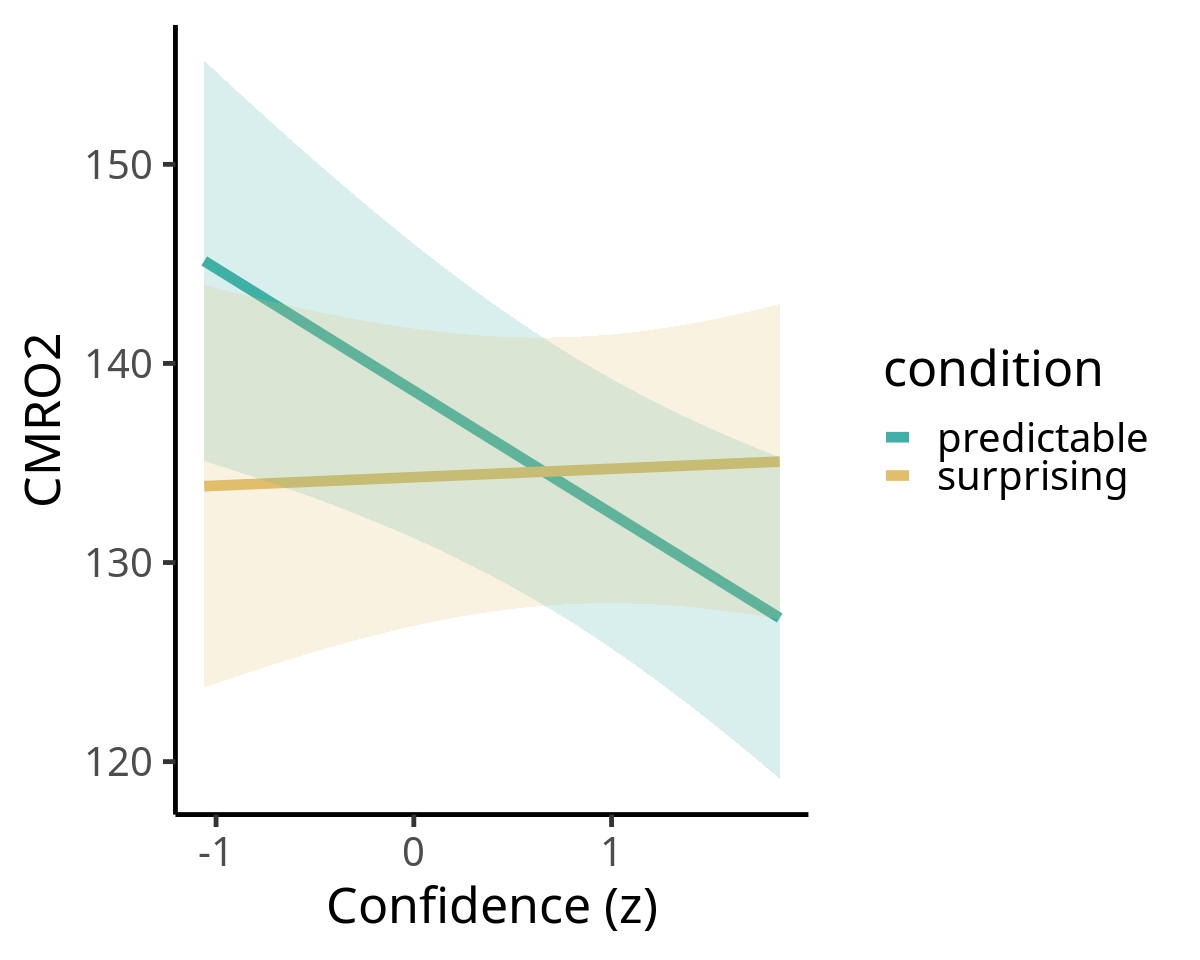

In [5]:
sim_slopes(confidence_model, pred=confidence_z, modx=condition, modx.values=c("predictable","surprising"))

options(repr.plot.width=10, repr.plot.height=8)

p = interact_plot(confidence_model, pred=confidence_z, modx=condition, modx.values=c("predictable","surprising"), interval=TRUE,
    vary.lty=F, colors=c("#40B0A6","#E1BE6A"), line.thickness=3,
    x.label='Confidence (z)')

p = p + theme_classic(base_size=30) + theme(text=element_text(family='Open Sans'))

p

## Network effects: Salience and control network

Warning message:
“confidence_z and network and condition are not included in an interaction
with one another in the model.”
Warning message:
“Johnson-Neyman intervals are not available for factor moderators.”


█████████████████ While condition (2nd moderator) = predictable ████████████████ 

SIMPLE SLOPES ANALYSIS 

Slope of confidence_z when network = Control: 

    Est.    S.E.   t val.       p
-------- ------- -------- -------
  -1.225   2.129   -0.575   0.566

Slope of confidence_z when network = SalVentAttn: 

    Est.    S.E.   t val.       p
-------- ------- -------- -------
  -3.387   2.142   -1.582   0.117

█████████████████ While condition (2nd moderator) = surprising █████████████████ 

SIMPLE SLOPES ANALYSIS 

Slope of confidence_z when network = Control: 

   Est.    S.E.   t val.       p
------- ------- -------- -------
  5.361   2.090    2.566   0.012

Slope of confidence_z when network = SalVentAttn: 

   Est.    S.E.   t val.       p
------- ------- -------- -------
  3.199   2.103    1.521   0.131


Warning message:
“confidence_z and network and condition are not included in an interaction
with one another in the model.”
Warning message:
“confidence_z and network and condition are not included in an interaction
with one another in the model.”


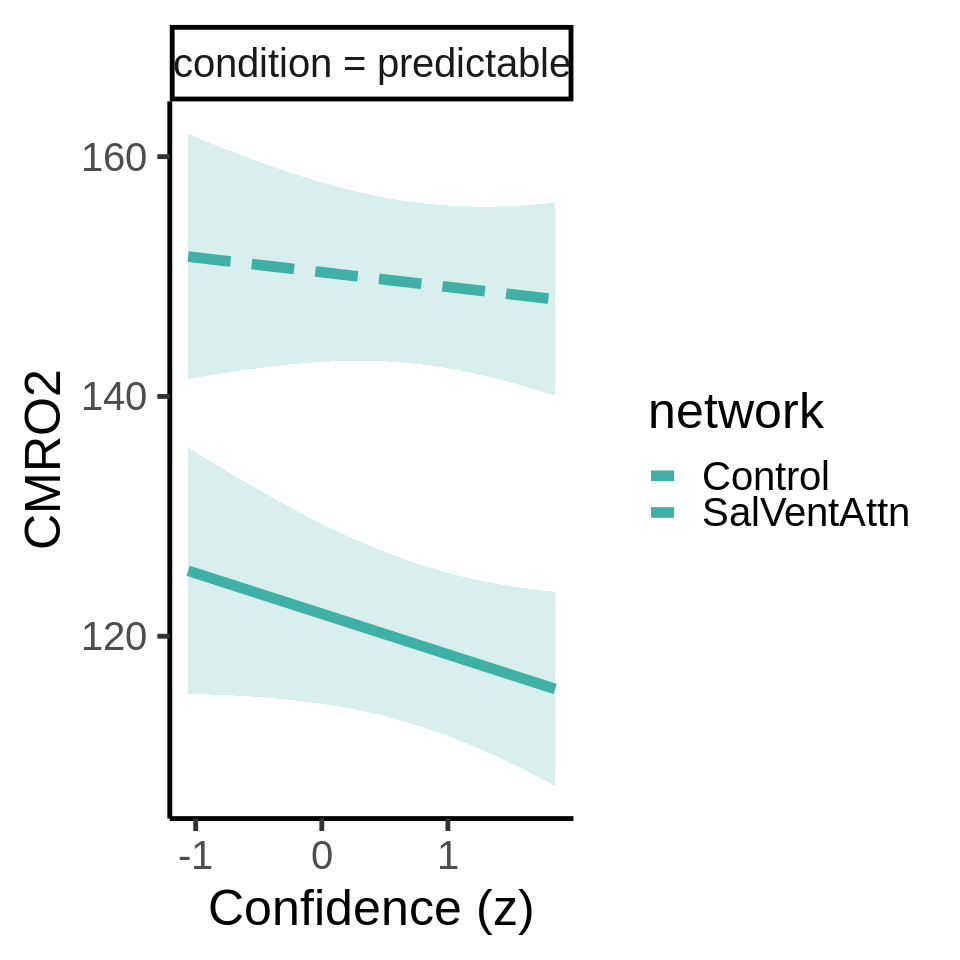

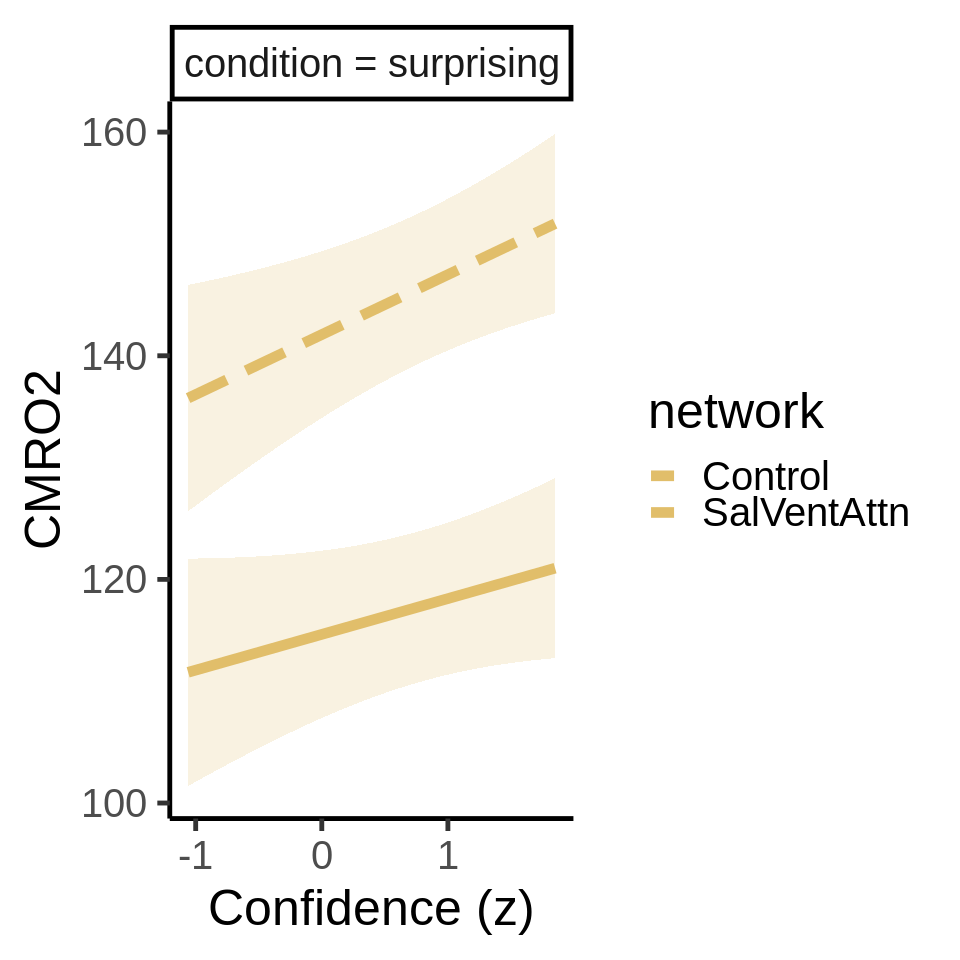

In [12]:
sim_slopes(confidence_model, pred=confidence_z, modx=network, mod2=condition,
                    modx.values=c("Control","SalVentAttn"),
                    mod2.values=c("predictable", "surprising"),
                    digits=3)

### Plot the interactions separately to adjust aesthetics in line with other figures
options(repr.plot.width=8, repr.plot.height=8)

p_pred = interact_plot(confidence_model, pred=confidence_z, modx=network, mod2=condition,
                    modx.values=c("Control","SalVentAttn"),
                    mod2.values=c("predictable"),
                    interval=TRUE,
                    vary.lty=T, colors=c("#40B0A6","#40B0A6"), line.thickness=3,
                    x.label='Confidence (z)')

p_pred + theme_classic(base_size=30)

p_surp = interact_plot(confidence_model, pred=confidence_z, modx=network, mod2=condition,
                    modx.values=c("Control","SalVentAttn"),
                    mod2.values=c("surprising"),
                    interval=TRUE,
                    vary.lty=T, colors=c("#E1BE6A","#E1BE6A"), line.thickness=3,
                    x.label='Confidence (z)')

p_surp + theme_classic(base_size=30)

# Regarding the warning: Note that the initial model selection found no evidence
    # for a significant three-way interaction
    # We here test the total effect of the reference effect and two-way interactions

In [56]:
utils:::print.sessionInfo(sessionInfo()[c(-10,-11)])

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggplot2_3.4.1      car_3.1-2          carData_3.0-5      dplyr_1.1.0       
 [5] interactions_1.1.5 see_0.7.4          report_0.5.6       parameters_0.20.2 
 [9] performance_0.10.2 modelbased_0.8.6   insight_0.19.0     effectsize_0.8.3  
[13] datawizard_0.6.5   correlation_0.8.3  bayestestR_0.13.0  easystats_0.6.0   
[17] lmerTest_3.1-3     lme4_1.1-31        Matrix_1.5-3  